In [1]:
import os
import pickle
from collections.abc import Callable
from pathlib import Path
from typing import Any

import cv2
import numpy as np
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from srcnn import SRCNN
from dataset import VideoFrameDataset

In [3]:
class VideoFrameDataset(Dataset):
    def __init__(
        self, video_path: str, transform: Callable[[np.ndarray], Any] = None
    ) -> None:
        self.frames: list[np.ndarray] = []
        capture = cv2.VideoCapture(video_path)
        while True:
            success, frame = capture.read()
            if not success:
                break
            self.frames.append(frame)

        self.transform = transform

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, index: int):
        frame = self.frames[index]
        if self.transform:
            frame = self.transform(frame)
        return frame

In [4]:
target_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)

input_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((180, 320)),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)


def transform(frame: np.ndarray) -> tuple[Tensor, Tensor]:
    return input_transform(frame), target_transform(frame)

In [5]:
video_path = os.fspath(Path.cwd().glob("*.mp4").__next__())
dataset = VideoFrameDataset(video_path, transform)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    pin_memory_device="cuda",
)

In [6]:
model_args = {
    "f1": 9,
    "f2": 1,
    "f3": 5,
    "n1": 64,
    "n2": 32,
    "qconfig": torch.ao.quantization.get_default_qat_qconfig("x86"),
}
device = "cuda"

In [7]:
model = SRCNN(**model_args).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

model.train()
epoch_losses = []
for epoch in range(1, 40 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, quant=False)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best.pth")
        torch.save(model.state_dict(), "best.pth")

    epoch_losses.append(epoch_loss)

Epoch 1: 100%|██████████| 151/151 [00:30<00:00,  4.99it/s, batch_loss=281]   


Epoch loss: 3193.2758504097037
Saving best.pth


Epoch 2: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=143]


Epoch loss: 205.09814736069433
Saving best.pth


Epoch 3: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=97.2]


Epoch loss: 116.18629402514325
Saving best.pth


Epoch 4: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=49.9]


Epoch loss: 80.16048305082005
Saving best.pth


Epoch 5: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=61.2]


Epoch loss: 67.79357258373538
Saving best.pth


Epoch 6: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=64.2]


Epoch loss: 62.01388496752606
Saving best.pth


Epoch 7: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=43.9]


Epoch loss: 60.7927492912242
Saving best.pth


Epoch 8: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=65.5]


Epoch loss: 57.34887251948679
Saving best.pth


Epoch 9: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=79.4]


Epoch loss: 56.43695500354893
Saving best.pth


Epoch 10: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=57.1]


Epoch loss: 57.352076372563445


Epoch 11: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=37.6]


Epoch loss: 54.508334557741684
Saving best.pth


Epoch 12: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=64.1]


Epoch loss: 53.72580131631813
Saving best.pth


Epoch 13: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=55.3]


Epoch loss: 55.394268301149076


Epoch 14: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=47.6]


Epoch loss: 54.90005393375624


Epoch 15: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=45.3]


Epoch loss: 52.59247255641104
Saving best.pth


Epoch 16: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=51.3]


Epoch loss: 51.83404863117546
Saving best.pth


Epoch 17: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=45.2]


Epoch loss: 51.93896524795633


Epoch 18: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=31.6]


Epoch loss: 51.27105945309266
Saving best.pth


Epoch 19: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=60.4]


Epoch loss: 50.66891391072052
Saving best.pth


Epoch 20: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=53.7]


Epoch loss: 55.75157285526099


Epoch 21: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=50.9]


Epoch loss: 50.01434808693185
Saving best.pth


Epoch 22: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=42.7]


Epoch loss: 49.75776604153462
Saving best.pth


Epoch 23: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=46.8]


Epoch loss: 49.388241357361245
Saving best.pth


Epoch 24: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=47.9]


Epoch loss: 49.440131117966004


Epoch 25: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=44.1]


Epoch loss: 50.43522268888966


Epoch 26: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=39.2]


Epoch loss: 48.60726907237476
Saving best.pth


Epoch 27: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=45.3]


Epoch loss: 50.399833338150124


Epoch 28: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=42.4]


Epoch loss: 48.188798058111935
Saving best.pth


Epoch 29: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=47.5]


Epoch loss: 47.80423634257538
Saving best.pth


Epoch 30: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=67.5]


Epoch loss: 50.84554310981801


Epoch 31: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, batch_loss=63.7]


Epoch loss: 49.019653547678566


Epoch 32: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=46.7]


Epoch loss: 46.87809369421952
Saving best.pth


Epoch 33: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=44.7]


Epoch loss: 46.84580027346579
Saving best.pth


Epoch 34: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=51.5]


Epoch loss: 47.68823920496252


Epoch 35: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=28.7]


Epoch loss: 47.456172917852335


Epoch 36: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=46.1]


Epoch loss: 45.70197502035179
Saving best.pth


Epoch 37: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=54.7]


Epoch loss: 46.838608394395436


Epoch 38: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=46.2]


Epoch loss: 46.492495997852046


Epoch 39: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=35.3]


Epoch loss: 45.924570462561604


Epoch 40: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=44.8]

Epoch loss: 44.56273335336849
Saving best.pth


Text(0, 0.5, 'Loss')

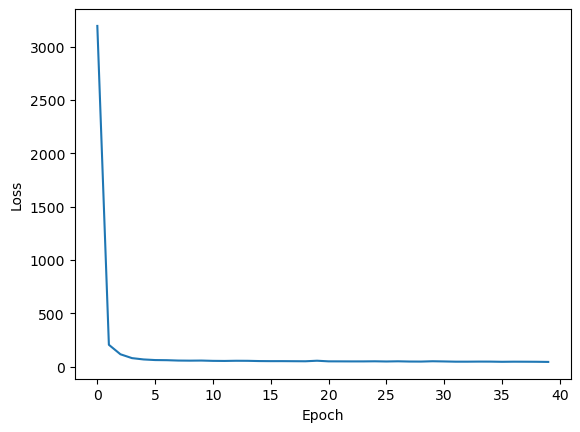

In [8]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
model = SRCNN(**model_args).to(device)
model.load_state_dict(torch.load("best.pth"))
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)

optimizer = Adam(model_qat.parameters(), lr=2e-5)

epoch_losses = []
for epoch in range(1, 40 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_qat(inputs, quant=True)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best_qat.pth")
        torch.save(model_qat.state_dict(), "best_qat.pth")

    epoch_losses.append(epoch_loss)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1:   0%|          | 0/151 [00:00<?, ?it/s]/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Us

Epoch loss: 58.037508377176245
Saving best_qat.pth


Epoch 2: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=46.9]


Epoch loss: 57.94073210962561
Saving best_qat.pth


Epoch 3: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=68.4]


Epoch loss: 57.78574785649382
Saving best_qat.pth


Epoch 4: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=43.7]


Epoch loss: 57.45123614380691
Saving best_qat.pth


Epoch 5: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=51.3]


Epoch loss: 57.74101237113902


Epoch 6: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=34.5]


Epoch loss: 56.83211893751132
Saving best_qat.pth


Epoch 7: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=54.3]


Epoch loss: 55.747979397805324
Saving best_qat.pth


Epoch 8: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=67.7]


Epoch loss: 55.00811148637178
Saving best_qat.pth


Epoch 9: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=76.2]


Epoch loss: 58.59718696644764


Epoch 10: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=48.9]


Epoch loss: 58.42849029136809


Epoch 11: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=62.5]


Epoch loss: 57.18898884350101


Epoch 12: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=68.4]


Epoch loss: 59.30430244294224


Epoch 13: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=60.3]


Epoch loss: 58.761335688711


Epoch 14: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=56.2]


Epoch loss: 57.504222768821464


Epoch 15: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=49.6]


Epoch loss: 55.19852048356012


Epoch 16: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=52.3]


Epoch loss: 54.40332005987104
Saving best_qat.pth


Epoch 17: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=52.5]


Epoch loss: 54.23112811158035
Saving best_qat.pth


Epoch 18: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=61]  


Epoch loss: 53.60201816685152
Saving best_qat.pth


Epoch 19: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=63]  


Epoch loss: 53.799536294495034


Epoch 20: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=46.4]


Epoch loss: 54.72204822262391


Epoch 21: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=49.1]


Epoch loss: 54.78930224488113


Epoch 22: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=55]  


Epoch loss: 54.26886754320157


Epoch 23: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=55.5]


Epoch loss: 54.20837078978684


Epoch 24: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=62.3]


Epoch loss: 53.51222092584269
Saving best_qat.pth


Epoch 25: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=60.1]


Epoch loss: 54.5239744881131


Epoch 26: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=46.2]


Epoch loss: 53.86099265900669


Epoch 27: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=53.7]


Epoch loss: 53.05753831673932
Saving best_qat.pth


Epoch 28: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=49.9]


Epoch loss: 53.18668865683853


Epoch 29: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=51.3]


Epoch loss: 52.57664300274375
Saving best_qat.pth


Epoch 30: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=51.8]


Epoch loss: 52.802284265985556


Epoch 31: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=49.6]


Epoch loss: 53.02567574204198


Epoch 32: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=64.5]


Epoch loss: 52.12983770559955
Saving best_qat.pth


Epoch 33: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=50]  


Epoch loss: 51.077322776743905
Saving best_qat.pth


Epoch 34: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=55.8]


Epoch loss: 51.439165532194224


Epoch 35: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=61.9]


Epoch loss: 51.45821832821069


Epoch 36: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=66.8]


Epoch loss: 51.78477878444242


Epoch 37: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=56.8]


Epoch loss: 52.50860935489074


Epoch 38: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=42.5]


Epoch loss: 52.405741104227026


Epoch 39: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=47.5]


Epoch loss: 51.57285622097798


Epoch 40: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=55.2]

Epoch loss: 51.21460803455075


Text(0, 0.5, 'Loss')

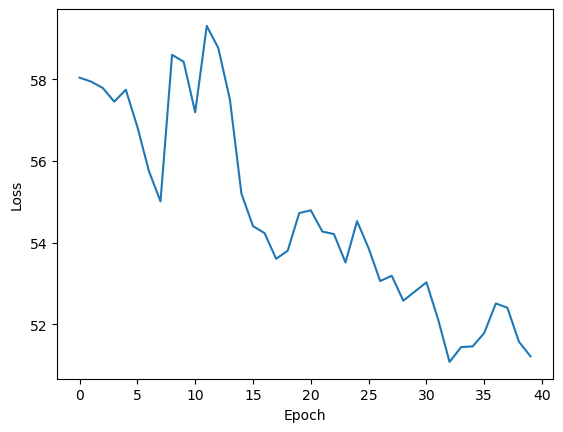

In [10]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [11]:
model = SRCNN(**model_args).to(device)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.load_state_dict(torch.load("best_qat.pth"))
model_qat.cpu()
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
torch.save(model_converted.state_dict(), "converted.pth")

In [7]:
def show_image(image: np.ndarray | Tensor) -> None:
    if isinstance(image, Tensor):
        image = image.cpu().detach().numpy()
    if image.shape[0] == 1:
        image = image.squeeze(0)
    if image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    image = image.clip(0, 255).astype(np.uint8)
    plt.axis("off")
    plt.imshow(image)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/_utils.py:404: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Text(0.5, 1.0, 'Target')

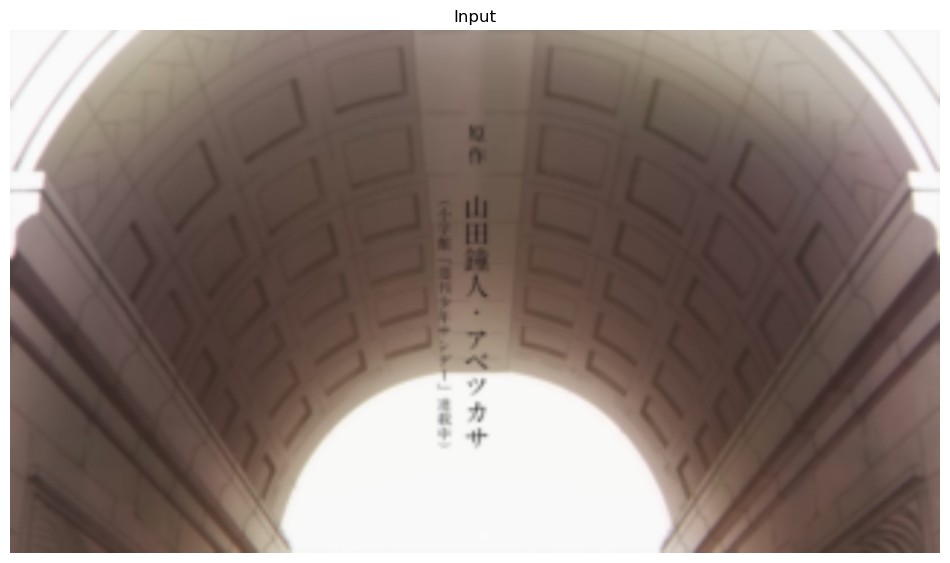

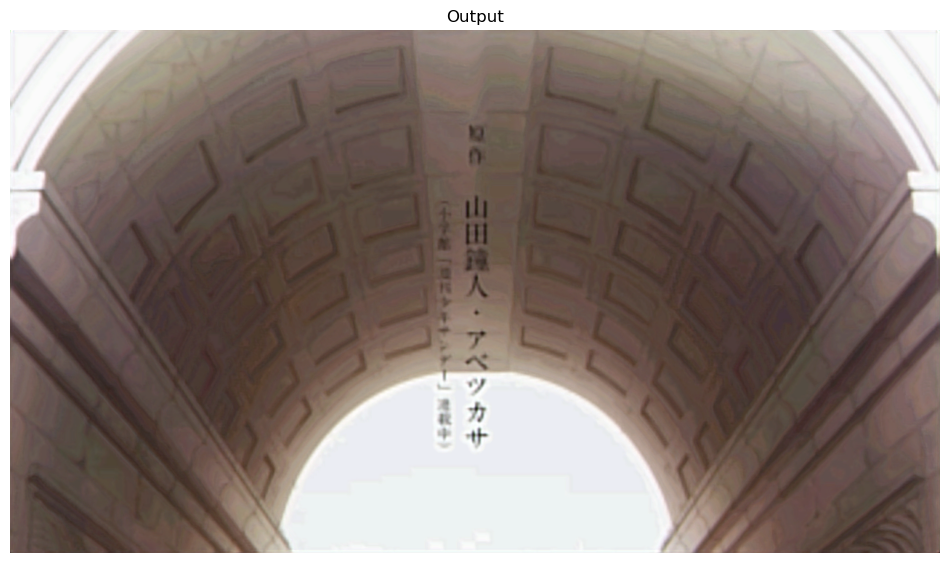

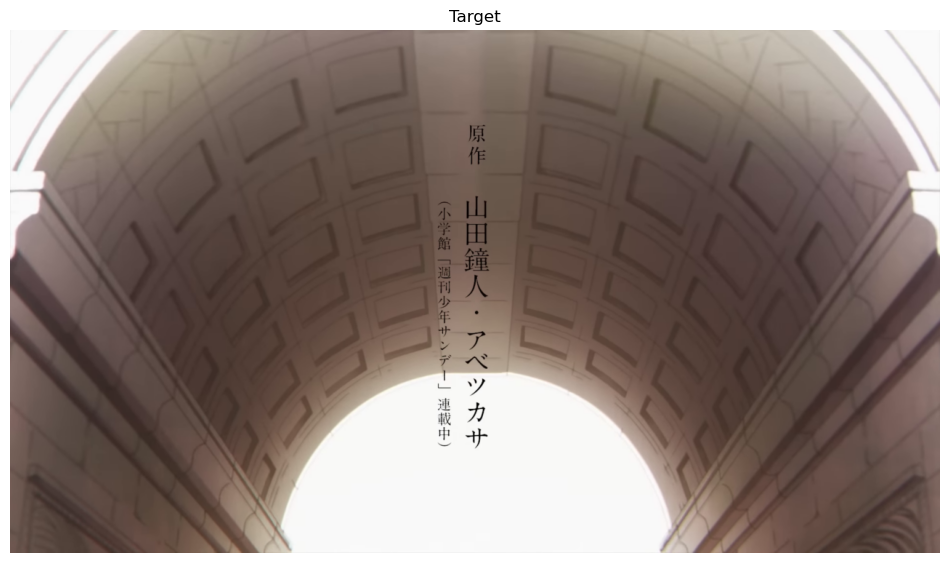

In [8]:
model = SRCNN(**model_args)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
model_converted.load_state_dict(torch.load("converted.pth"))

test_input, test_target = dataset[100]
test_input = test_input.unsqueeze(0)
test_output = model_converted(test_input, quant=True)

FIGURE_SIZE = (12, 8)

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_target)
plt.title("Target")

In [9]:
s = [21, 13, 14]

u = []
v = []
weights = []

x_scale_keys = ["quant.scale", "conv_layers.0.scale", "conv_layers.1.scale"]
x_zero_point_keys = [
    "quant.zero_point",
    "conv_layers.0.zero_point",
    "conv_layers.2.zero_point",
]

for i in range(3):
    conv_layers_weight = model_converted.state_dict()[f"conv_layers.{i}.weight"]
    bias = model_converted.state_dict()[f"conv_layers.{i}.bias"]

    x_scale = model_converted.state_dict()[x_scale_keys[i]]
    y_scale = model_converted.state_dict()[f"conv_layers.{i}.scale"]
    A_scale = conv_layers_weight.q_per_channel_scales()

    u.append(x_scale / y_scale * A_scale * (2 ** s[i]))
    v.append((bias / y_scale) * (2 ** s[i]))

    A_q = conv_layers_weight.int_repr()
    x_0 = model_converted.state_dict()[x_zero_point_keys[i]]

    weight = A_q * u[i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    weights.append(weight)

weights[0] = weights[0] / model_converted.state_dict()["quant.scale"]
weights[2] = weights[2] * y_scale

Text(0.5, 1.0, 'Output')

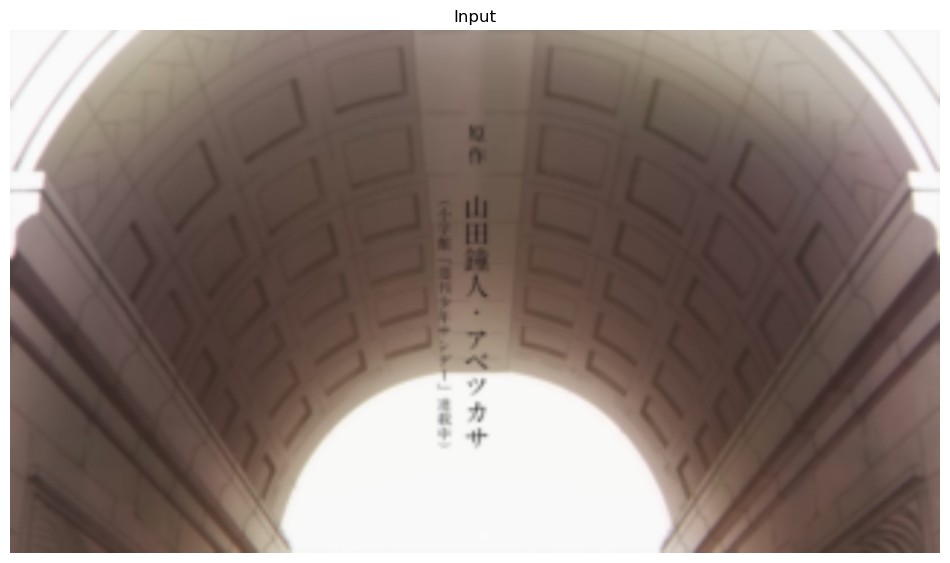

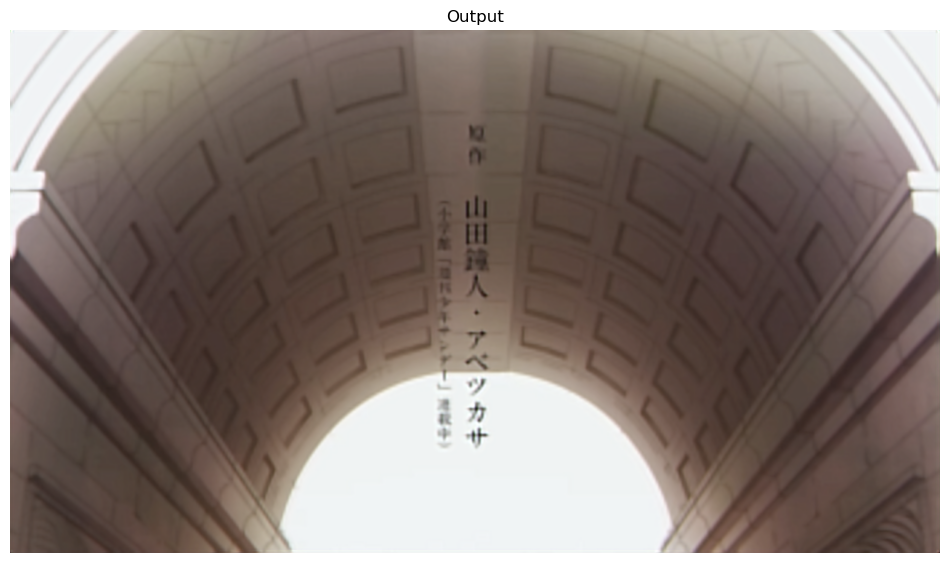

In [10]:
ACTIVATION_SHIFT = 2

ACTIVATION_WIDTH = 16
ACTIVATION_MIN = -(2 ** (ACTIVATION_WIDTH - 1))
ACTIVATION_MAX = 2 ** (ACTIVATION_WIDTH - 1) - 1

WEIGHT_WIDTH = 25
WEIGHT_MIN = -(2 ** (WEIGHT_WIDTH - 1))
WEIGHT_MAX = 2 ** (WEIGHT_WIDTH - 1) - 1

DSP_OUTPUT_WIDTH = 48
DSP_OUTPUT_MIN = -(2 ** (DSP_OUTPUT_WIDTH - 1))
DSP_OUTPUT_MAX = 2 ** (DSP_OUTPUT_WIDTH - 1) - 1

test_output = test_input.double() * (2**ACTIVATION_SHIFT)

for i, weight in enumerate(weights):
    assert weight.min() >= WEIGHT_MIN, f"Weight {i} min: {weight.min()}"
    assert weight.max() <= WEIGHT_MAX, f"Weight {i} max: {weight.max()}"

    test_output = (
        F.conv2d(
            test_output, weight.double().round(), v[i].double().round(), padding="same"
        )
        .double()
        .round()
    )
    assert test_output.min() >= DSP_OUTPUT_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= DSP_OUTPUT_MAX, f"Output {i} max: {test_output.max()}"

    test_output = F.relu(test_output * (2 ** -s[i])).double().floor()
    assert test_output.min() >= ACTIVATION_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= ACTIVATION_MAX, f"Output {i} max: {test_output.max()}"

test_output = (test_output * (2**-ACTIVATION_SHIFT)).double().floor()

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

In [11]:
with open("weights.pkl", "wb") as fp:
    pickle.dump(weights, fp)
with open("biases.pkl", "wb") as fp:
    pickle.dump(v, fp)